In [105]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import random
import time
%matplotlib inline
# %matplotlib notebook

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [3]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]

In [4]:
df = load_region('C:/Users/DJFRO/Hubs/Clustering/county1000.csv')

In [5]:
data = np.asarray(df[DAYS_SUM[4]*24*4:DAYS_SUM[7]*24*4]).astype('float16').T

In [6]:
blds, t_len = data.shape

In [7]:
num_days = t_len//(24*4)
num_days

92

In [8]:
data_days = data.reshape(blds,num_days,24*4)

<IPython.core.display.Javascript object>


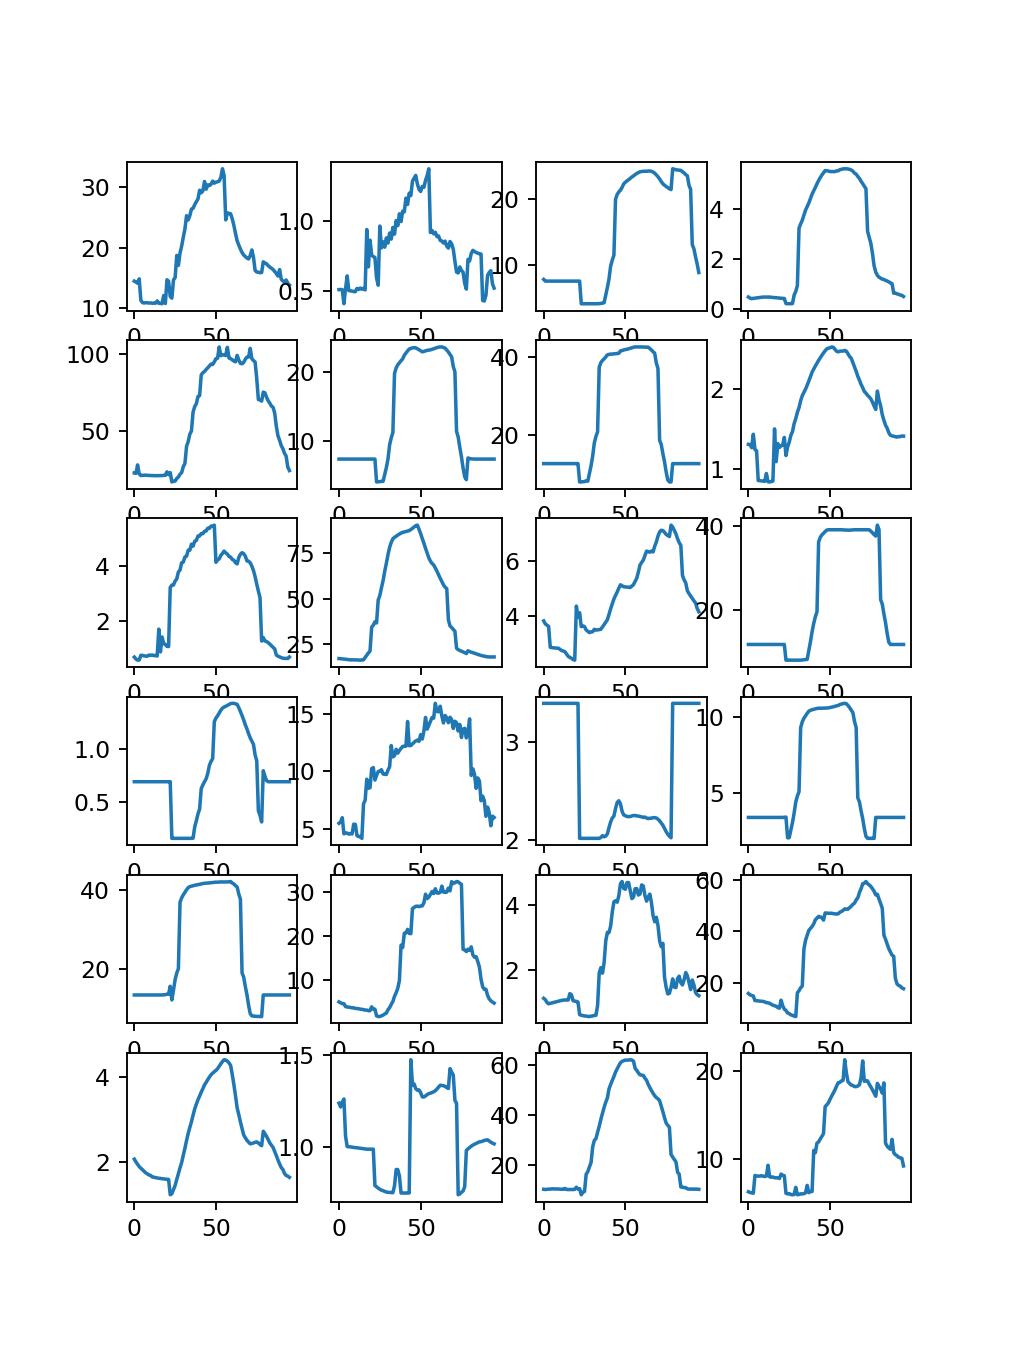

In [9]:
plt.subplots(6,4, figsize = (6,8))
for i in range(24):
    plt.subplot(6,4,i+1)
    bld = np.random.randint(0,blds)
    day = np.random.randint(0,num_days)
    plt.plot(data_days[bld,day,:])

In [13]:
two_days = np.zeros((blds,num_days-1,24*4*2))
for i in range(num_days-1):
    two_days[:,i,:] = np.concatenate([data_days[:,i,:],data_days[:,i+1,:]],axis=1)

In [20]:
two_days.shape,data_days.shape

((1085, 91, 192), (1085, 92, 96))

<IPython.core.display.Javascript object>


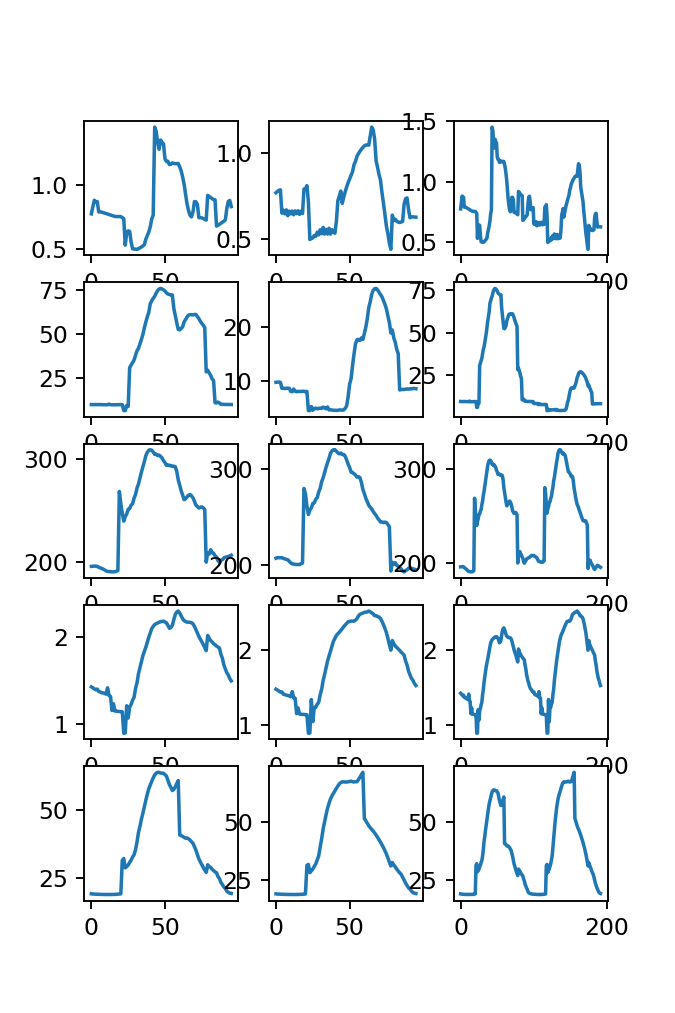

In [14]:
plt.subplots(5,3, figsize = (4,6))
for i in range(0,15,3):
    plt.subplot(5,3,i+1)
    bld = np.random.randint(0,blds)
    day = np.random.randint(0,num_days)
    plt.plot(data_days[bld,day,:])
    plt.subplot(5,3,i+2)
    plt.plot(data_days[bld,day+1,:])
    plt.subplot(5,3,i+3)
    plt.plot(two_days[bld,day,:])

In [15]:
def riseNfall(above,below):
    above = list((above))
    below = list((below))
    jumps = []
    ai,bi = 0,0
    start = True
    while (ai < len(above) and bi < len(below)):
        if above[ai] < below[bi]:
            jumps += [[above[ai], 1]]
            ai += 1
        else:
            jumps += [[below[bi], -1]]
            bi += 1
    jumps = np.asarray(jumps)
    rise,fall = 0,0
    for j in range(1,len(jumps)):
        if jumps[j,1] + jumps[j - 1, 1] == 0:
            diff = jumps[j,0] - jumps[j - 1, 0]
            if jumps[j, 1] < 0:
                fall = (diff)
            else:
                rise = (diff)
        if rise > 0 and fall > 0:
            break
    return jumps, rise,fall

In [19]:
# n_peak = np.percentile(two_days,95,axis=2,keepdims=True)
# n_base = np.percentile(two_days,5,axis=2,keepdims=True)
# high_load_dur = np.sum((two_days>.5*(n_peak+n_base)).astype(int),axis=(1,2),keepdims=True)

# percentiles with low sig figs can be tricky, say... the 95% might also be the maximum when values repeat 

# rise_times_days = np.zeros((blds,num_days-1))
# fall_times_days = np.zeros((blds,num_days-1))
# records = {}
# for b in range(blds):
#     records[b] = []
#     for d in range(num_days-1):
#         arr = two_days[b,d,:]
#         above_peak = (arr>=n_peak[b,d,0]).astype(int)
#         below_base = (arr<=n_base[b,d,0]).astype(int) 
#         above_ind = np.nonzero(above_peak)[0]
#         below_ind = np.nonzero(below_base)[0]
#         jumps,rise,fall = riseNfall(above_ind,below_ind)
#         rise_times_days[b,d] = rise
#         fall_times_days[b,d] = fall
#         records[b].append(jumps)
        
# fall_times = np.mean(fall_times_days,axis=1)
# rise_times = np.mean(rise_times_days,axis=1)

# plt.hist(fall_times, bins = 50)
# plt.hist(rise_times, bins = 50)
# plt.title('Histogram: Building Avg Rise/Fall Time w 95/5 Percentiles')
# plt.legend(['fall','rise'])
# plt.show()

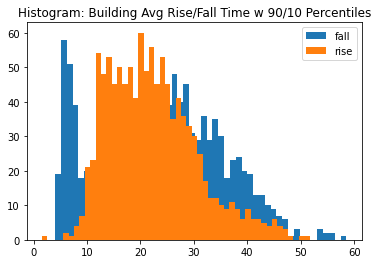

In [18]:
n_peak = np.percentile(two_days,90,axis=2,keepdims=True)
n_base = np.percentile(two_days,10,axis=2,keepdims=True)
high_load_dur = np.sum((two_days>.5*(n_peak+n_base)).astype(int),axis=(1,2),keepdims=True)

rise_times_days = np.zeros((blds,num_days-1))
fall_times_days = np.zeros((blds,num_days-1))
records = {}
for b in range(blds):
    records[b] = []
    for d in range(num_days-1):
        arr = two_days[b,d,:]
        above_peak = (arr>=n_peak[b,d,0]).astype(int)
        below_base = (arr<=n_base[b,d,0]).astype(int) 
        above_ind = np.nonzero(above_peak)[0]
        below_ind = np.nonzero(below_base)[0]
        jumps,rise,fall = riseNfall(above_ind,below_ind)
        rise_times_days[b,d] = rise
        fall_times_days[b,d] = fall
        records[b].append(jumps)
        
fall_times = np.mean(fall_times_days,axis=1)
rise_times = np.mean(rise_times_days,axis=1)

plt.hist(fall_times, bins = 50)
plt.hist(rise_times, bins = 50)
plt.title('Histogram: Building Avg Rise/Fall Time w 90/10 Percentiles')
plt.legend(['fall','rise'])
plt.show()

In [24]:
n_peak_day = np.percentile(data_days,90,axis=2,keepdims=True)
n_base_day = np.percentile(data_days,10,axis=2,keepdims=True)
load_dur_day = np.sum((data_days>.5*(n_peak_day+n_base_day)).astype(int),axis=(1,2),keepdims=True)

(1085, 1, 1) (1085, 1, 1)


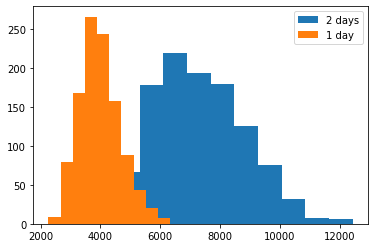

In [29]:
print(high_load_dur.shape, load_dur_day.shape)
#former used two day data, later used a single day
plt.hist(high_load_dur[:,0,0])
plt.hist(load_dur_day[:,0,0])
plt.legend(['2 days', '1 day'])

In [43]:
new_params = (
    np.concatenate([np.mean(n_peak,axis=1),
                   np.mean(n_base,axis=1),
                   np.mean(load_dur_day,axis=1),
                   (fall_times).reshape(blds,1),
                   (rise_times).reshape(blds,1)], 
                   axis=1
    ))

In [47]:
new_params_n = (new_params-np.mean(new_params,keepdims=True,axis=0))/np.std(new_params,axis=0)

In [38]:
#old params, using two days for the high load dur
params = (
    np.concatenate([np.mean(n_peak,axis=1),
                   np.mean(n_base,axis=1),
                   np.mean(high_load_dur,axis=1),
                   (fall_times).reshape(blds,1),
                   (rise_times).reshape(blds,1)]
                  ,axis=1))

In [39]:
params_n = (params-np.mean(params,keepdims=True,axis=0))/np.std(params,axis=0)

In [48]:
np.max(new_params_n), np.min(new_params_n), new_params_n.shape, params_n.shape

(22.12405668104079, -2.5209225391330166, (1085, 5), (1085, 5))

In [50]:
k_dbis_new = []
for i in range(2,200):
    clust = KMeans(i).fit(new_params_n)
    k_dbis_new.append(davies_bouldin_score(new_params_n, clust.labels_))
    #print(np.round(eps,4),set(clust.labels_))


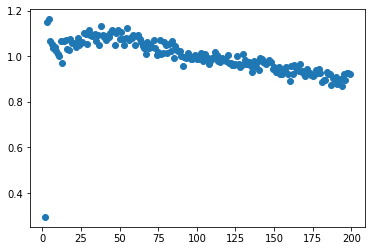

In [51]:
plt.scatter(np.arange(2,200),k_dbis_new)

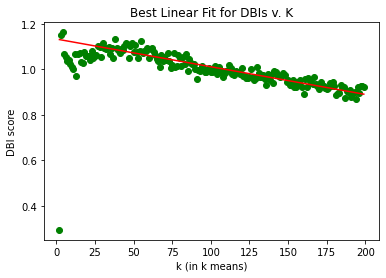

Text(0.5, 1.0, 'Residuals')

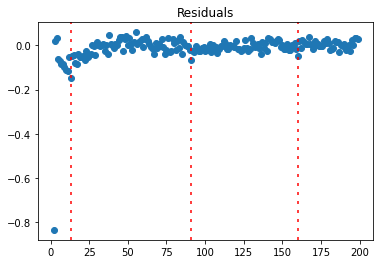

In [82]:
from sklearn.linear_model import LinearRegression
y,x = np.asarray(k_dbis_new).reshape(198,1), np.arange(2,200).reshape(198,1)
model = LinearRegression()
model.fit(x[25:], y[25:])

pred = model.predict(x)
plt.scatter(x, y,color='g')
plt.plot(x, pred,color='r')
plt.title('Best Linear Fit for DBIs v. K')
plt.xlabel('k (in k means)')
plt.ylabel('DBI score')
plt.show()


residuals = y - pred
plt.scatter(x,residuals)
plt.axvline(x=11+2,color = 'r', dashes = (2,4))
plt.axvline(x=89+2,color = 'r', dashes = (2,4))
plt.axvline(x=158+2,color = 'r', dashes = (2,4))
plt.title('Residuals')

In [75]:
np.argsort(residuals[:,0])
#11, 89 and 158

array([  0,  11,   9,   8,   7,   5,  15,   6,  14,   4,  89,  20,   3,
        22,  10,  17,  18,  12,  19, 158,  27,  23,  13,  65,  24,  72,
        83,  35, 134,  16, 106, 185,  75,  91, 102, 192,  94,  90,  21,
        33,  95, 126, 138,  45,  76,  98, 121, 179, 189, 152, 122, 153,
        79,  73,  88,  51,  99, 113,  93, 107, 150, 149, 119,  64, 120,
       104, 157, 180, 112, 168, 127,  67, 160, 181, 136,  39, 123, 125,
       100,  96, 133,  81,  58, 117, 105,  97, 130, 147,  63,  71, 155,
        30, 173,  69, 131, 108, 187, 190,  92, 172, 116, 115,  86,  87,
       174, 109,  26, 191,  38,  29, 114,  25, 186,  85, 154, 167, 170,
        34,  31,  48, 194, 103,  41, 148, 151, 164, 101, 171,  68,  40,
       132, 188,  54, 166,  62,  32, 163,  37,  50, 176, 178, 129, 143,
       156,  78, 137, 111,  66, 183, 162,  52, 184, 142, 135, 141,  84,
        55,  28,  56, 144,  61, 118, 159, 182, 169, 110, 175,  80,   1,
       124, 146, 193,  42, 161, 140,  77,  70,  59, 177,  46, 14

In [85]:
good_clust = {}
for i in np.random.rand(100)*6 - 3:
    eps = np.round(np.exp(i),5)
    
    clust = DBSCAN(eps=eps).fit(params_n)
    #print(np.round(eps,4),set(clust.labels_))
    if len(set(clust.labels_)) > 2:
        good_clust[eps]=clust

In [87]:
dbscan_dbis = {}
for i in good_clust.keys():
    dbscan_dbis[i] = (davies_bouldin_score(new_params_n, good_clust[i].labels_))

In [88]:
dbscan_dbis

{0.54064: 2.0412483202945517,
 0.27026: 1.848039377212854,
 0.58022: 2.4490160536293275,
 0.52616: 2.0724062236176164,
 0.25696: 1.4960998578929676,
 0.61177: 2.839402013332227,
 0.60645: 2.877003292070165,
 0.18566: 1.3810102568838207,
 0.495: 1.7629370914340932,
 0.23603: 1.6076208525600613,
 0.3497: 1.898876135915575,
 0.46575: 1.8184251041922663,
 0.26023: 1.488821821773237,
 0.43299: 1.7057662515194623,
 0.17996: 1.2887136977779707,
 0.45329: 1.6454518143081234,
 0.53312: 2.0481867648776335,
 0.17933: 1.2887136977779707}

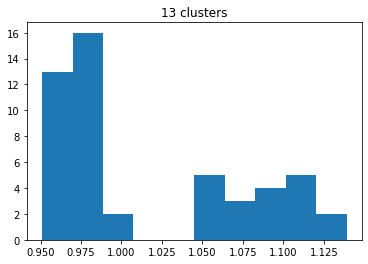

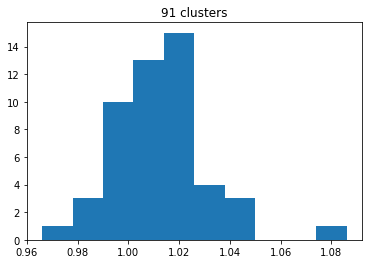

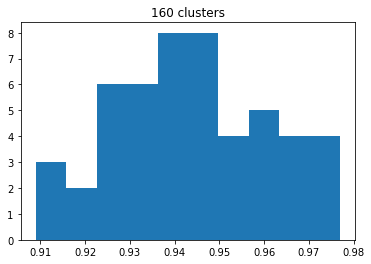

In [103]:
best_Kv2 = {}
for k in range(50):
    for i in [13,91,160]:
        clust = KMeans(i).fit(new_params_n)
        dbi = np.round(davies_bouldin_score(new_params_n, clust.labels_),3)
        if i not in best_Kv2.keys():
            best_Kv2[i] = []
        best_Kv2[i].append(dbi)
for i in best_Kv2.keys():
    plt.hist(best_Kv2[i])
    plt.title(str(i)+ ' clusters')
    plt.show()

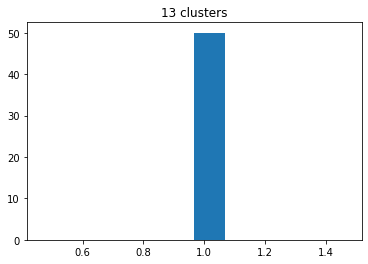

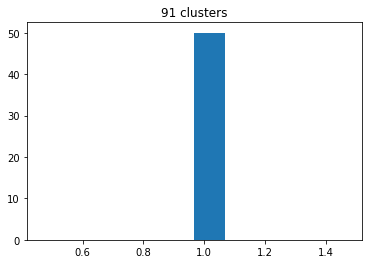

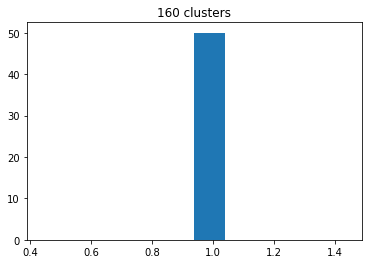

In [104]:
best_Kv2 = {}
clusts= {}
for i in [13,91,160]:
    clusts[i] = KMeans(i).fit(new_params_n)

for k in range(50):
    for i in [13,91,160]:

        dbi = np.round(davies_bouldin_score(new_params_n, clusts[i].labels_),3)
        if i not in best_Kv2.keys():
            best_Kv2[i] = []
        best_Kv2[i].append(dbi)
for i in best_Kv2.keys():
    plt.hist(best_Kv2[i])
    plt.title(str(i)+ ' clusters')
    plt.show()

# Kmeans' dbi distribution (80 clusterings per k)

In [112]:
opt_clust={}
opt_dbis={}
kmean_dbis={}
t0 = time.time()
for i in range(80):
    for k in range(5,300):
        clust =  KMeans(k).fit(new_params_n)
        dbi = np.round(davies_bouldin_score(new_params_n, clust.labels_),3)
        if i ==0 or dbi<opt_dbis[k]:
            opt_dbis[k] = dbi
            opt_clust[k] = clust.labels_
            if i ==0:
                kmean_dbis[k] = []
        kmean_dbis[k].append(dbi)
    dtm = np.round((time.time()-t0)/60,2)
    if (i+1) %5==0:
        print(dtm, ' time passed. ', i+1, ' runs completed')
        
        

24.56  time passed.  5  runs completed
49.78  time passed.  10  runs completed
74.62  time passed.  15  runs completed
99.64  time passed.  20  runs completed
124.49  time passed.  25  runs completed
149.42  time passed.  30  runs completed
174.22  time passed.  35  runs completed
199.13  time passed.  40  runs completed
224.39  time passed.  45  runs completed
249.73  time passed.  50  runs completed
275.6  time passed.  55  runs completed
322.15  time passed.  60  runs completed
362.49  time passed.  65  runs completed
387.2  time passed.  70  runs completed
412.14  time passed.  75  runs completed
437.32  time passed.  80  runs completed


In [115]:
kmean_dbi_stats = np.zeros((295,4))
for k in range(5,300):
    arr = np.asarray(kmean_dbis[k])
    #we'll do min, mean, std, max
    kmean_dbi_stats[k-5,0] = np.min(arr)
    kmean_dbi_stats[k-5,1] = np.mean(arr)
    kmean_dbi_stats[k-5,2] = np.std(arr)
    kmean_dbi_stats[k-5,3] = np.max(arr)

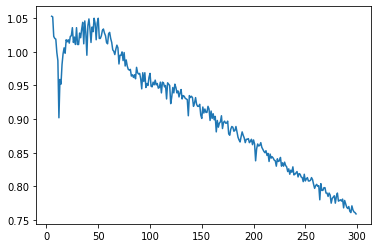

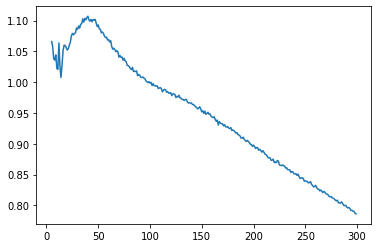

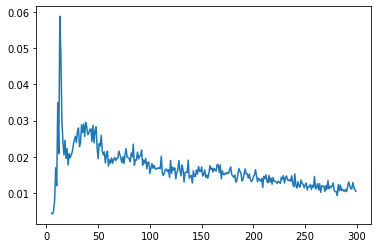

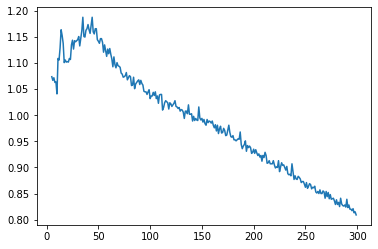

In [117]:
for i in range(4):
    plt.plot(np.arange(5,300),kmean_dbi_stats[:,i])
    plt.show()

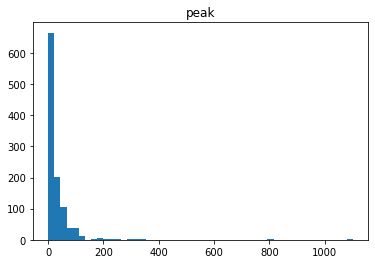

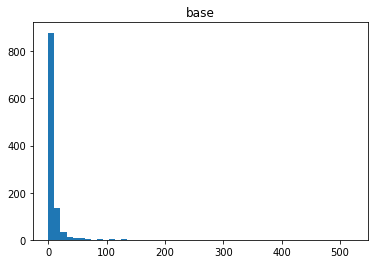

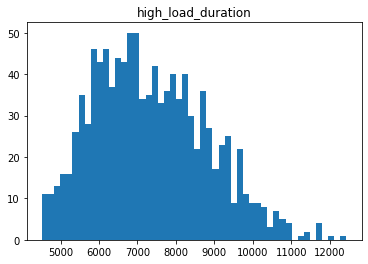

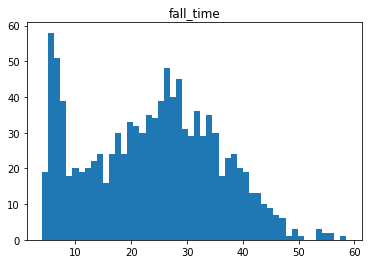

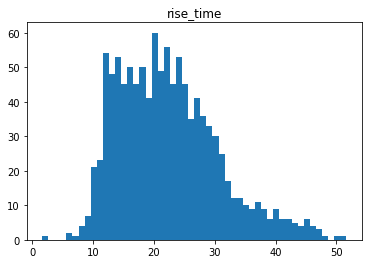

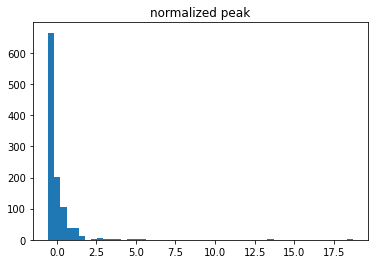

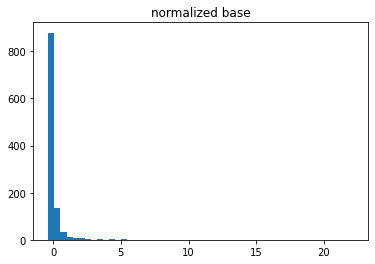

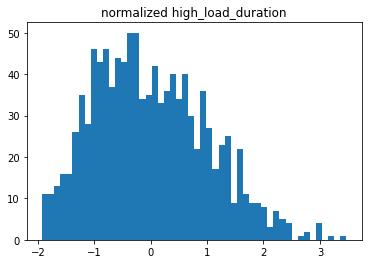

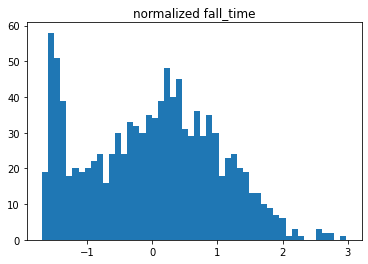

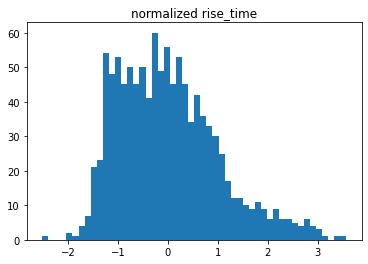

In [34]:
%matplotlib inline
params_lst = ['peak','base','high_load_duration','fall_time','rise_time']
for i in range(5):
    plt.hist(params[:,i],bins=50)
    plt.title(params_lst[i])
    plt.show()
    
for i in range(5):
    plt.hist(params_n[:,i],bins=50)
    plt.title('normalized '+params_lst[i])
    plt.show()

In [16]:
select_cluster = Kmeans(112).fit(params_n)

NameError: name 'Kmeans' is not defined

## Saving the clustering

In [15]:
np.save('kmeans112.npy',select_cluster.labels_)

In [53]:
lbls = select_cluster.labels_

In [54]:
lengths = []
for i in range(112):
    count = np.sum((lbls==i).astype(int))
    lengths.append(count)

<IPython.core.display.Javascript object>


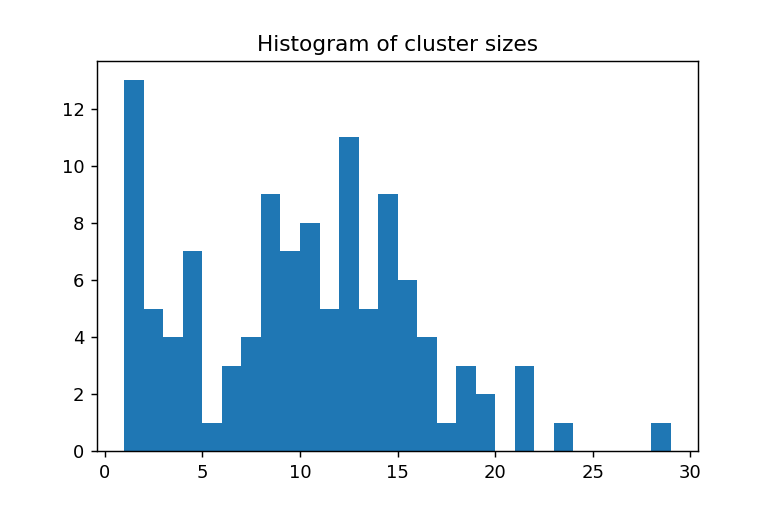

Text(0.5, 1.0, 'Histogram of cluster sizes')

In [69]:
plt.hist(lengths,bins=28)
plt.title('Histogram of cluster sizes')

## Various buildings per cluster. 
### each column is a cluster

<IPython.core.display.Javascript object>


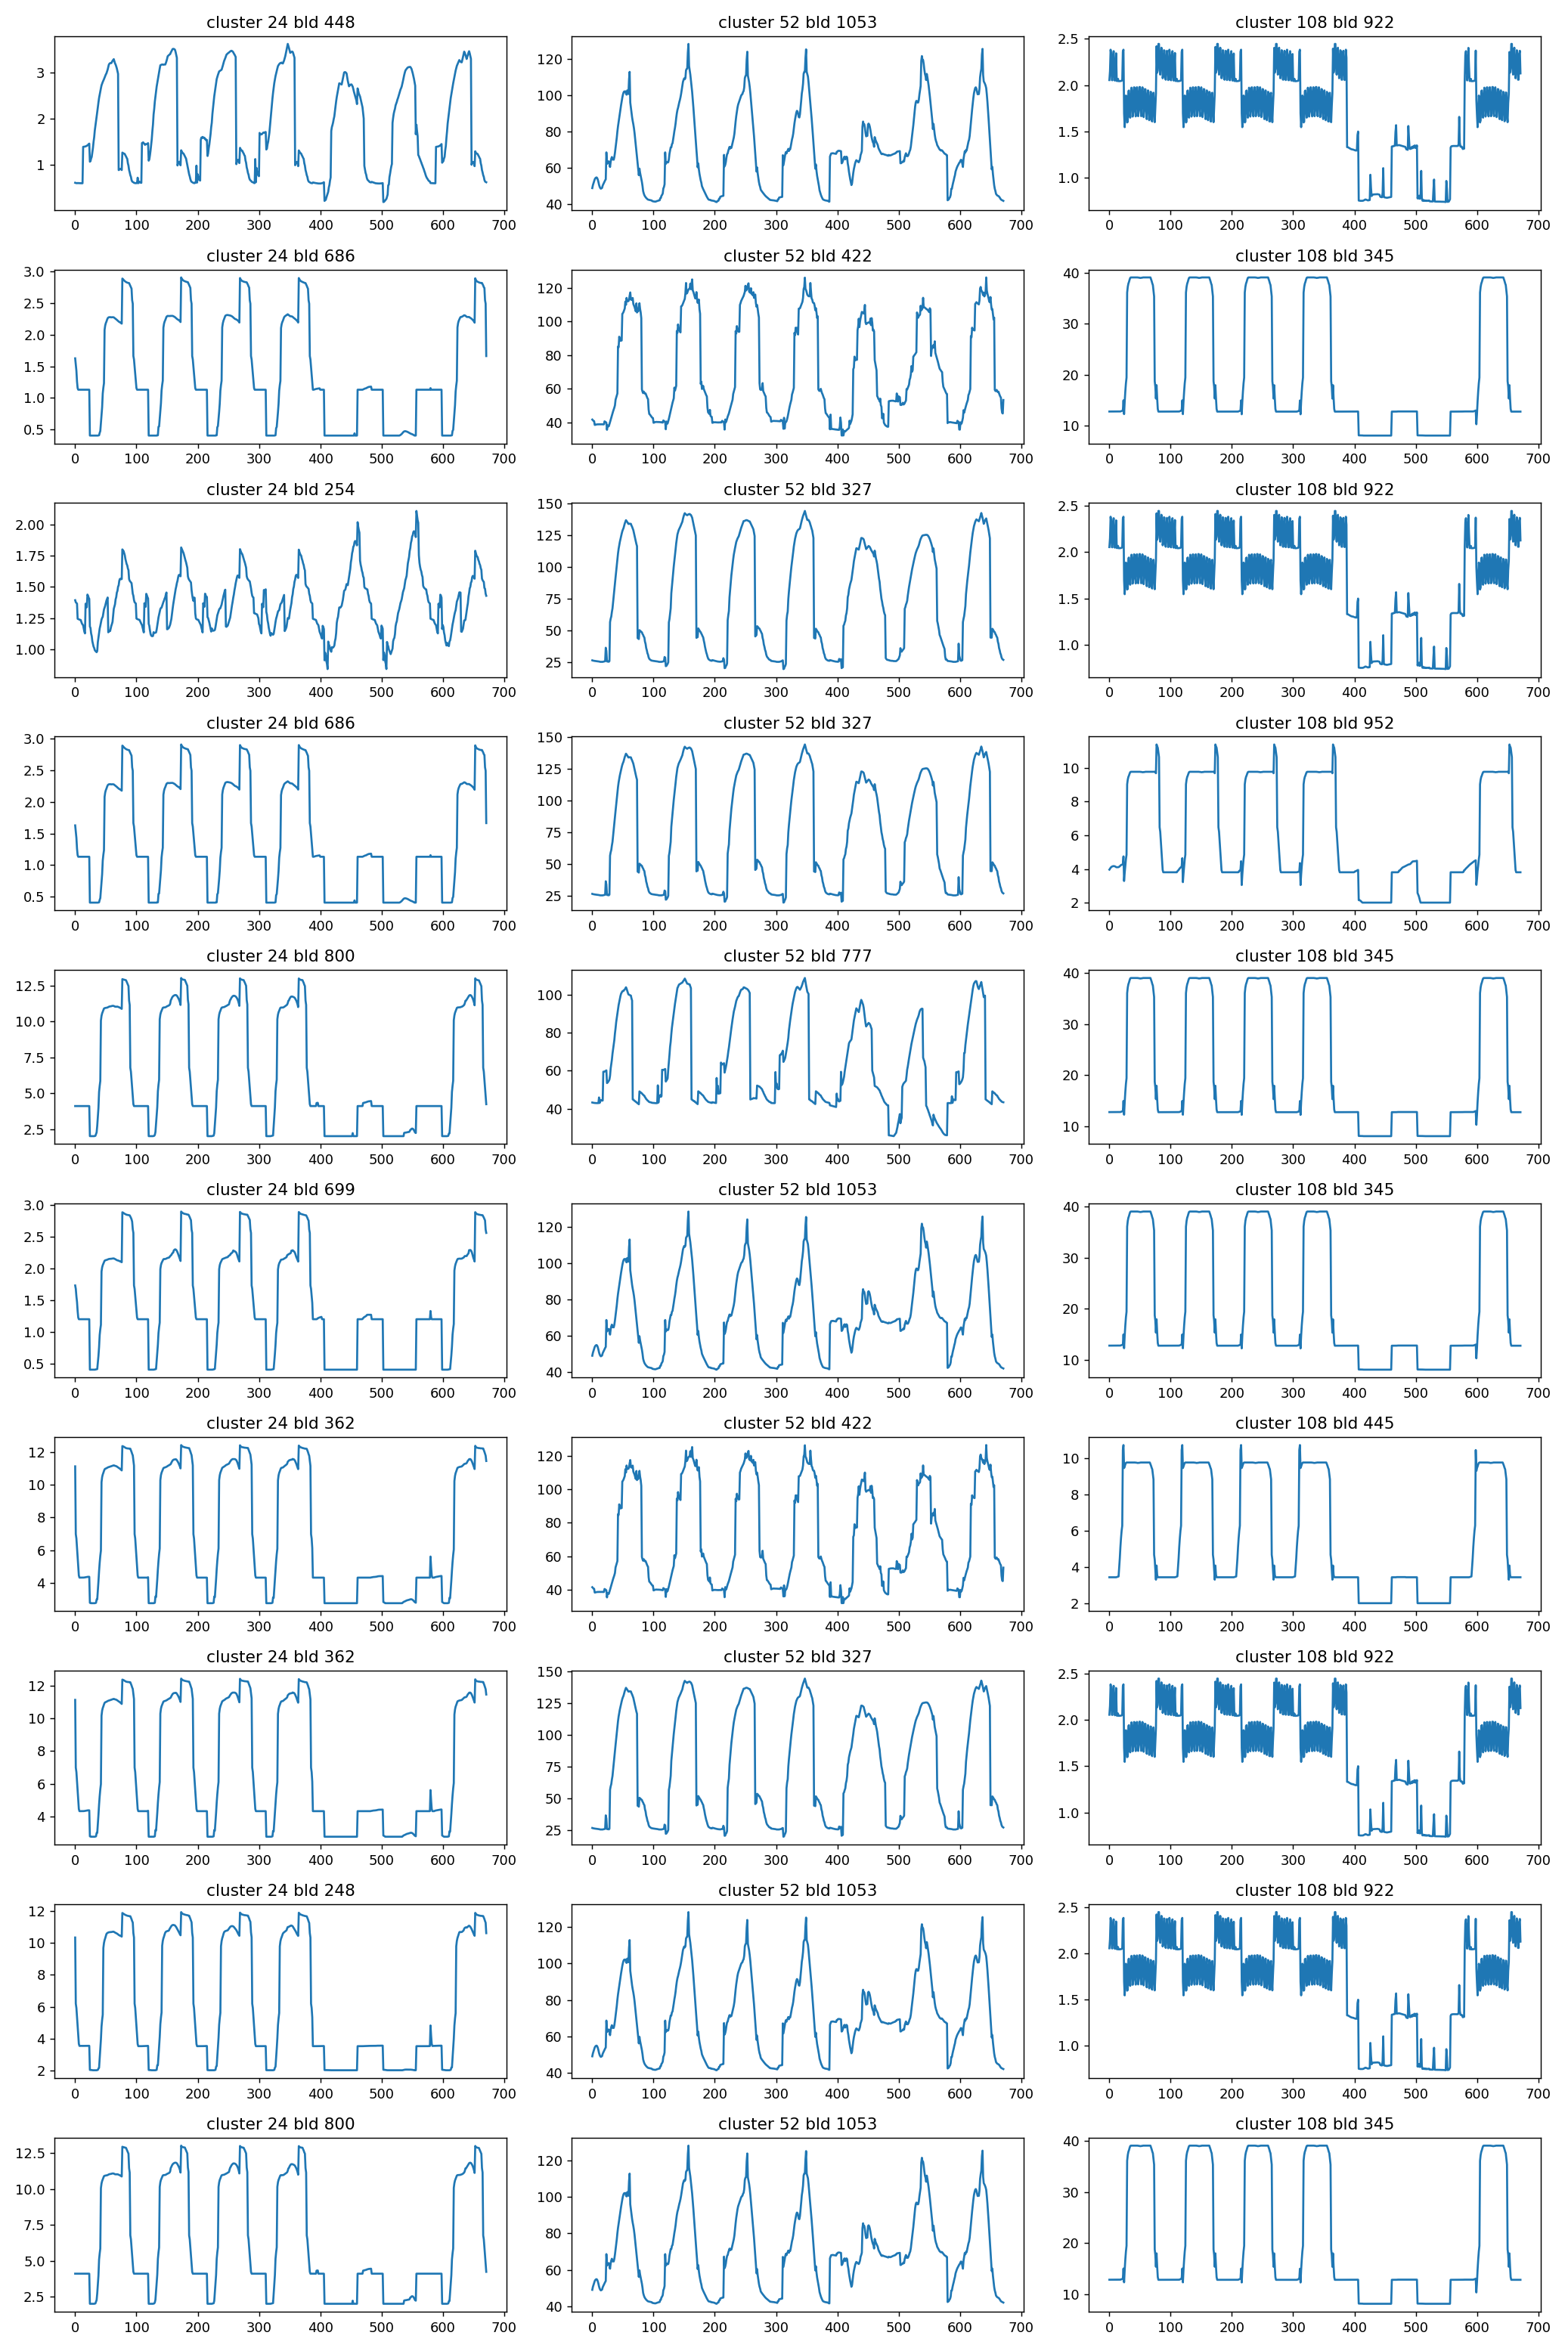

In [65]:
plt.subplots(10,3,figsize=(16,24))
clusters = np.random.randint(0,len(set(select_cluster.labels_)),3)
for i in range(10):
    for j in range(3):
        bld = np.random.choice(np.squeeze(np.argwhere((lbls==clusters[j]).astype(int)))) 
        plt.subplot(10,3,i*3+j+1)
        plt.plot(data[bld,:24*4*7])
        plt.title('cluster '+str(clusters[j])+' bld '+str(bld))
plt.tight_layout()

<IPython.core.display.Javascript object>


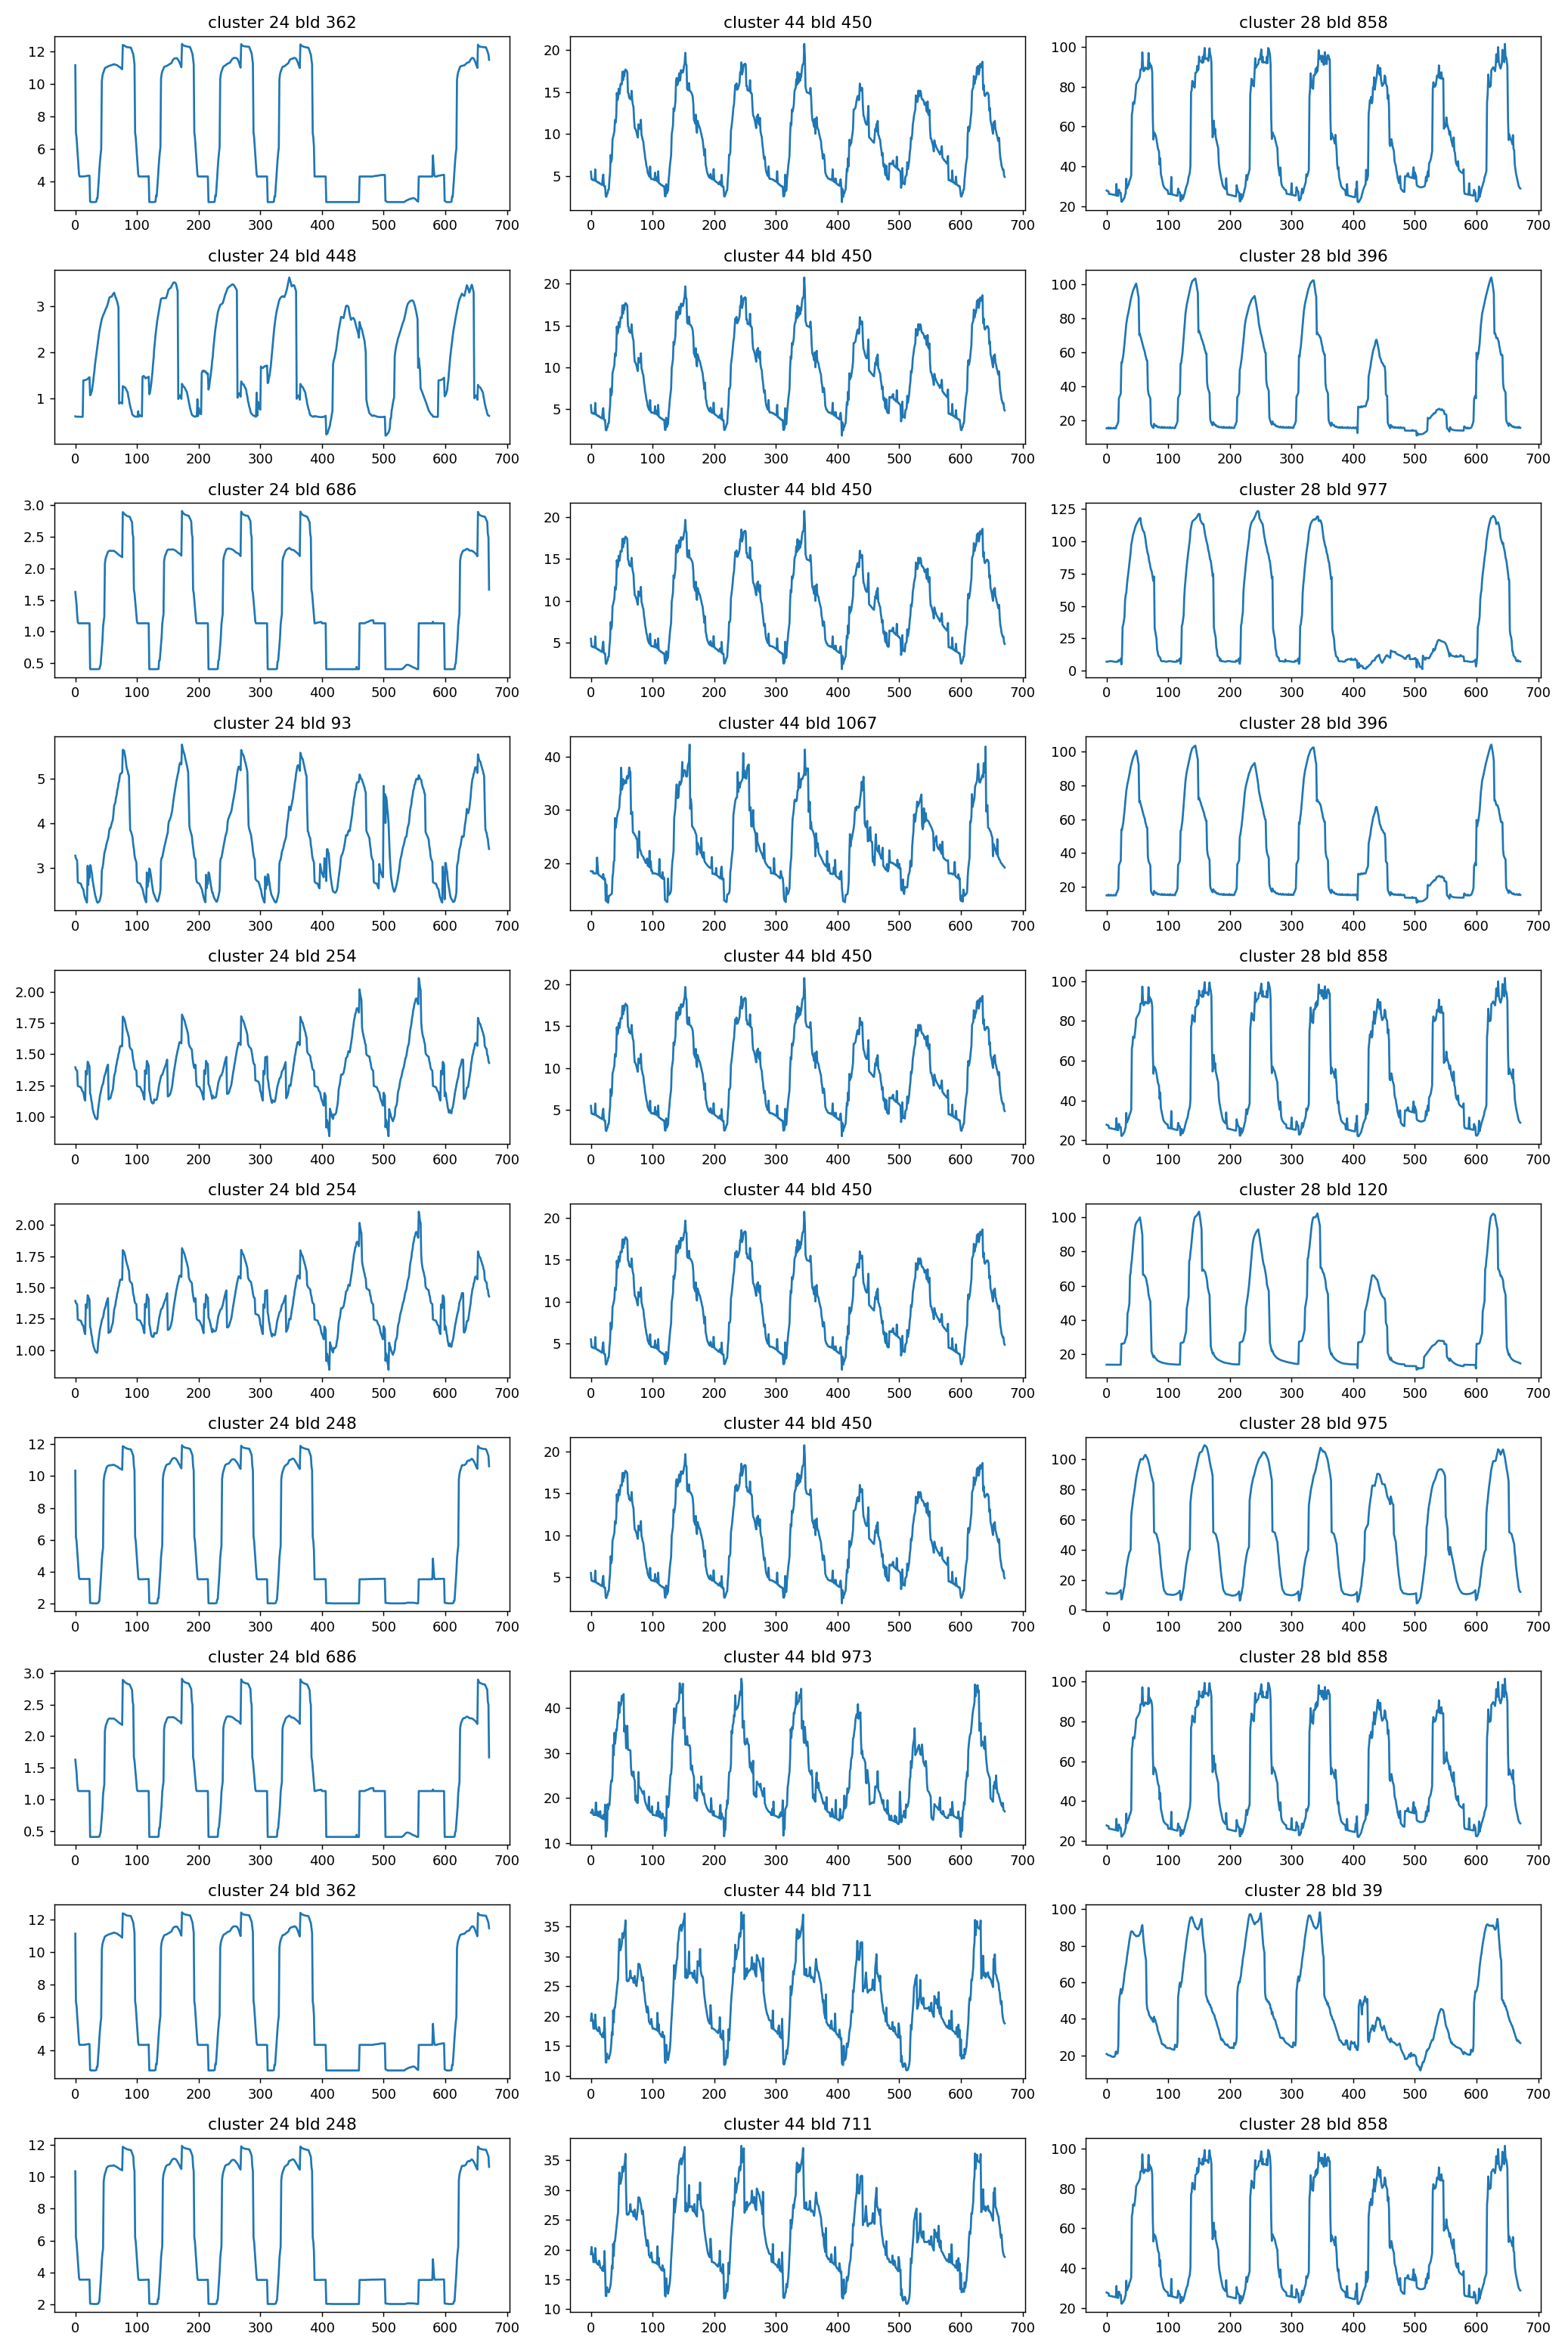

In [68]:
plt.subplots(10,3,figsize=(16,24))
clusters = np.random.randint(0,len(set(select_cluster.labels_)),3)
for i in range(10):
    for j in range(3):
        bld = np.random.choice(np.squeeze(np.argwhere((lbls==clusters[j]).astype(int)))) 
        plt.subplot(10,3,i*3+j+1)
        plt.plot(data[bld,:24*4*7])
        plt.title('cluster '+str(clusters[j])+' bld '+str(bld))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


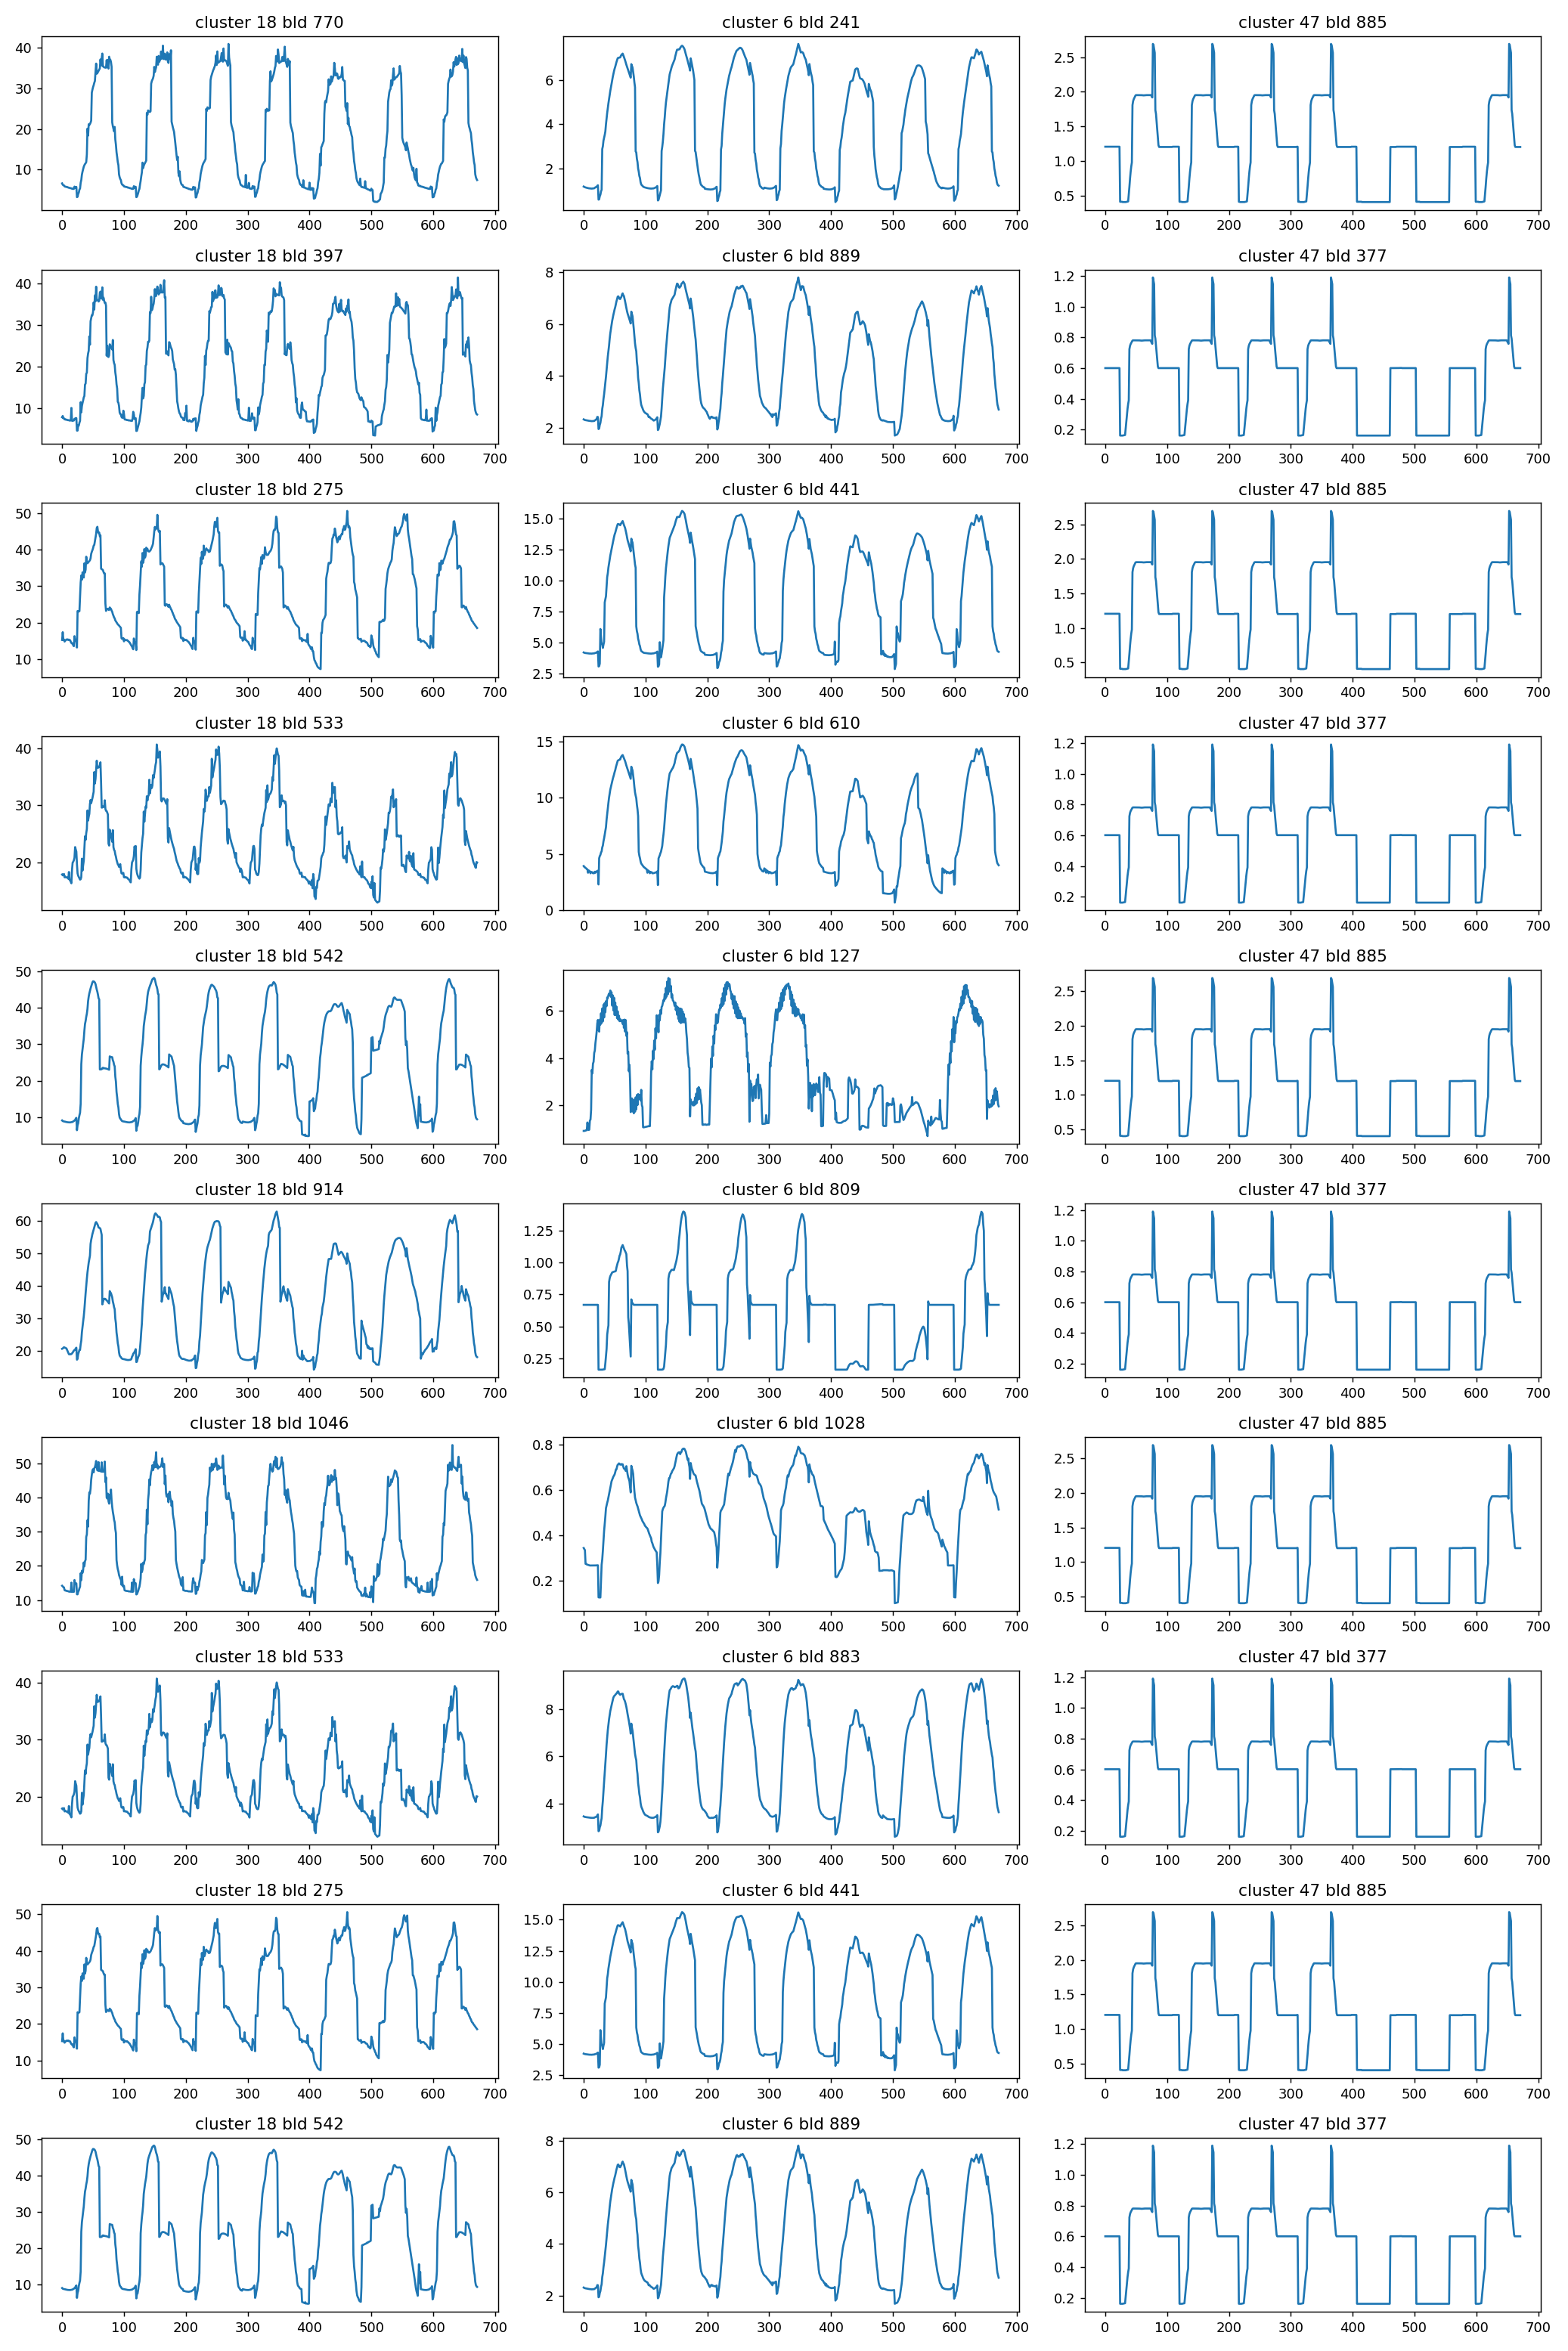

In [70]:
plt.subplots(10,3,figsize=(16,24))
clusters = np.random.randint(0,len(set(select_cluster.labels_)),3)
for i in range(10):
    for j in range(3):
        bld = np.random.choice(np.squeeze(np.argwhere((lbls==clusters[j]).astype(int)))) 
        plt.subplot(10,3,i*3+j+1)
        plt.plot(data[bld,:24*4*7])
        plt.title('cluster '+str(clusters[j])+' bld '+str(bld))
plt.tight_layout()
plt.show()